In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import matplotlib.patheffects as PathEffects
import pickle

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.tree import _tree, DecisionTreeClassifier
from IPython.display import display, HTML
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

### Data Generation 
Most work of this step is finished using the Google BigQuery to generate this raw data from the MIMIC III dataset.  
This table includes the important features for AKI stages prediction and the corresponding AKI stages labels. The sensitive information has been deidentified according to the HIPPA.

In [2]:
# Load the dataset
df = pd.read_csv("/content/Raw_aki_patient_data.csv")
# And get a peek of the first five lines of it
df.head()

,creat,uo_rt_6hr,uo_rt_12hr,uo_rt_24hr,aki_stage,ANIONGAP_min,ANIONGAP_max,ALBUMIN_min,ALBUMIN_max,BANDS_min,BANDS_max,BICARBONATE_min,BICARBONATE_max,BILIRUBIN_min,BILIRUBIN_max,CREATININE_min,CREATININE_max,CHLORIDE_min,CHLORIDE_max,GLUCOSE_min,GLUCOSE_max,HEMATOCRIT_min,HEMATOCRIT_max,HEMOGLOBIN_min,HEMOGLOBIN_max,LACTATE_min,LACTATE_max,PLATELET_min,PLATELET_max,POTASSIUM_min,POTASSIUM_max,PTT_min,PTT_max,INR_min,INR_max,PT_min,PT_max,SODIUM_min,SODIUM_max,BUN_min,BUN_max,WBC_min,WBC_max,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min_1,Glucose_Max_1,Glucose_Mean
0,NaN,1.8030,1.2149,1.2727,0,11.0,14.0,NaN,NaN,NaN,NaN,30.0,32.0,0.3,0.6,0.6,0.8,99.0,106.0,100.0,118.0,20.2,27.7,6.4,8.9,1.0,1.6,431.0,533.0,3.4,4.2,32.6,47.3,2.0,5.6,21.1,48.0,139.0,144.0,12.0,15.0,7.1,11.6,82.0,115.0,93.011429,74.0,144.0,106.331361,33.0,94.0,48.668639,51.333302,110.667,67.889548,8.0,38.0,19.578475,36.722221,39.444444,37.829806,12.0,100.0,98.679558,97.0,123.0,108.500000
1,NaN,0.1437,0.1646,0.1782,3,15.0,20.0,1.9,2.6,8.0,22.0,12.0,21.0,0.3,0.7,1.0,1.6,97.0,105.0,94.0,189.0,25.7,36.8,8.5,12.1,2.1,12.9,41.0,640.0,3.4,4.4,32.3,79.6,1.3,1.9,14.5,20.3,127.0,134.0,15.0,24.0,40.7,56.3,34.0,191.0,116.306122,49.0,137.0,106.650794,34.0,102.0,64.728000,27.000000,220.000,78.516949,12.0,35.0,23.348624,35.722222,38.833333,37.454106,70.0,100.0,93.792683,94.0,243.0,142.714286
2,NaN,1.0916,0.8270,0.7497,0,19.0,27.0,3.0,3.5,NaN,NaN,11.0,19.0,3.4,4.9,1.3,2.0,107.0,111.0,42.0,180.0,31.2,39.3,10.9,13.7,4.8,10.8,47.0,63.0,3.3,3.9,38.0,44.9,3.0,6.2,21.3,30.6,142.0,145.0,21.0,24.0,4.3,8.1,31.0,133.0,119.409091,75.0,159.0,109.756098,39.0,75.0,54.365854,53.000000,91.000,71.350000,15.0,37.0,34.680000,37.444445,38.333333,37.896825,18.0,100.0,90.266667,42.0,270.0,133.769231
3,0.9,NaN,NaN,NaN,1,10.0,24.0,3.2,3.9,NaN,NaN,18.0,30.0,1.0,1.6,0.6,1.6,96.0,108.0,74.0,184.0,21.5,36.0,7.4,11.9,1.1,7.8,262.0,543.0,3.6,7.6,27.2,39.5,1.1,1.9,12.5,20.0,134.0,140.0,13.0,25.0,6.8,19.0,75.0,124.0,100.254237,86.0,165.0,123.777778,23.0,89.0,59.196581,47.000000,106.000,79.355556,11.0,33.0,21.883721,36.111111,39.055557,37.166667,56.0,100.0,96.131579,74.0,208.0,128.380000
4,NaN,15.6182,15.6182,15.6182,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,113.0,113.0,101.0,101.0,31.7,31.7,10.2,10.2,2.2,2.2,79.0,79.0,3.6,3.6,23.7,23.7,1.1,1.1,13.2,13.2,144.0,144.0,34.0,34.0,10.9,10.9,44.0,92.0,80.727273,136.0,136.0,136.000000,66.0,66.0,66.000000,82.000000,82.000,82.000000,6.0,29.0,14.750000,35.722222,35.722222,35.722222,43.0,100.0,94.300000,NaN,NaN,NaN


In [3]:
# Get a peek of the features
print(list(df.columns))

['creat', 'uo_rt_6hr', 'uo_rt_12hr', 'uo_rt_24hr', 'aki_stage', 'ANIONGAP_min', 'ANIONGAP_max', 'ALBUMIN_min', 'ALBUMIN_max', 'BANDS_min', 'BANDS_max', 'BICARBONATE_min', 'BICARBONATE_max', 'BILIRUBIN_min', 'BILIRUBIN_max', 'CREATININE_min', 'CREATININE_max', 'CHLORIDE_min', 'CHLORIDE_max', 'GLUCOSE_min', 'GLUCOSE_max', 'HEMATOCRIT_min', 'HEMATOCRIT_max', 'HEMOGLOBIN_min', 'HEMOGLOBIN_max', 'LACTATE_min', 'LACTATE_max', 'PLATELET_min', 'PLATELET_max', 'POTASSIUM_min', 'POTASSIUM_max', 'PTT_min', 'PTT_max', 'INR_min', 'INR_max', 'PT_min', 'PT_max', 'SODIUM_min', 'SODIUM_max', 'BUN_min', 'BUN_max', 'WBC_min', 'WBC_max', 'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min_1', 'Glucose_Max_1', 'Glucose_Mean']


## Data Preprocessing

In [4]:
# Take look at percenatge of missing values per feature(column)
per_missing = df.isnull().sum()*100/len(df)
per_missing_df = pd.DataFrame(
    {"Feature Name": df.columns,
     "Missing Percentage": per_missing}
)
# Sort the percentage in a descending order
per_missing_df.sort_values(ascending=False, by="Missing Percentage", inplace=True)
per_missing_df

,Feature Name,Missing Percentage
BANDS_min,BANDS_min,81.926444
BANDS_max,BANDS_max,81.926444
uo_rt_12hr,uo_rt_12hr,68.288378
uo_rt_24hr,uo_rt_24hr,68.288378
uo_rt_6hr,uo_rt_6hr,68.288378
...,...,...
HEMATOCRIT_min,HEMATOCRIT_min,0.825415
HeartRate_Max,HeartRate_Max,0.224627
HeartRate_Min,HeartRate_Min,0.224627
HeartRate_Mean,HeartRate_Mean,0.224627


In [5]:
per_missing_df["Missing Percentage"].values

array([81.92644358, 81.92644358, 68.28837823, 68.28837823, 68.28837823,
       51.95122386, 51.95122386, 41.70395593, 41.70395593, 39.77501649,
       39.77501649, 32.9720286 , 12.63080955, 12.63080955, 12.33487244,
       12.33487244, 12.32952418, 12.32952418,  6.91886688,  6.91886688,
        6.91886688,  6.71028471,  6.71028471,  6.71028471,  6.68532615,
        6.68532615,  6.68532615,  6.65501934,  6.65501934,  6.65501934,
        6.65323659,  6.65323659,  6.65323659,  6.64254007,  6.64254007,
        6.64254007,  6.46604746,  6.46604746,  6.46604746,  6.18793789,
        6.18793789,  5.69411513,  5.69411513,  5.69411513,  5.69411513,
        2.41384843,  2.41384843,  2.37106234,  2.37106234,  2.11434582,
        2.11434582,  2.08225625,  2.08225625,  2.03590466,  2.03590466,
        1.04112813,  1.04112813,  1.03221436,  1.03221436,  1.00012479,
        1.00012479,  0.82541494,  0.82541494,  0.22462696,  0.22462696,
        0.22462696,  0.        ])

In [6]:
per_missing_df.at["BANDS_min", "Missing Percentage"]

81.92644358476102

In [7]:
# Drop the feature if the missing percenatge is greater than 40 percent
for feature in per_missing_df["Feature Name"].values:
  if per_missing_df.at[feature, "Missing Percentage"] >= 40:
    df.drop([feature], inplace=True, axis=1)
print(df.columns)

Index(['creat', 'aki_stage', 'ANIONGAP_min', 'ANIONGAP_max', 'BICARBONATE_min',
       'BICARBONATE_max', 'CREATININE_min', 'CREATININE_max', 'CHLORIDE_min',
       'CHLORIDE_max', 'GLUCOSE_min', 'GLUCOSE_max', 'HEMATOCRIT_min',
       'HEMATOCRIT_max', 'HEMOGLOBIN_min', 'HEMOGLOBIN_max', 'LACTATE_min',
       'LACTATE_max', 'PLATELET_min', 'PLATELET_max', 'POTASSIUM_min',
       'POTASSIUM_max', 'PTT_min', 'PTT_max', 'INR_min', 'INR_max', 'PT_min',
       'PT_max', 'SODIUM_min', 'SODIUM_max', 'BUN_min', 'BUN_max', 'WBC_min',
       'WBC_max', 'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean',
       'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max',
       'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min_1', 'Glucose_Max_1', 'Glucose_Mean'],
      dtype='object')


In [8]:
df.head()

,creat,aki_stage,ANIONGAP_min,ANIONGAP_max,BICARBONATE_min,BICARBONATE_max,CREATININE_min,CREATININE_max,CHLORIDE_min,CHLORIDE_max,GLUCOSE_min,GLUCOSE_max,HEMATOCRIT_min,HEMATOCRIT_max,HEMOGLOBIN_min,HEMOGLOBIN_max,LACTATE_min,LACTATE_max,PLATELET_min,PLATELET_max,POTASSIUM_min,POTASSIUM_max,PTT_min,PTT_max,INR_min,INR_max,PT_min,PT_max,SODIUM_min,SODIUM_max,BUN_min,BUN_max,WBC_min,WBC_max,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min_1,Glucose_Max_1,Glucose_Mean
0,NaN,0,11.0,14.0,30.0,32.0,0.6,0.8,99.0,106.0,100.0,118.0,20.2,27.7,6.4,8.9,1.0,1.6,431.0,533.0,3.4,4.2,32.6,47.3,2.0,5.6,21.1,48.0,139.0,144.0,12.0,15.0,7.1,11.6,82.0,115.0,93.011429,74.0,144.0,106.331361,33.0,94.0,48.668639,51.333302,110.667,67.889548,8.0,38.0,19.578475,36.722221,39.444444,37.829806,12.0,100.0,98.679558,97.0,123.0,108.500000
1,NaN,3,15.0,20.0,12.0,21.0,1.0,1.6,97.0,105.0,94.0,189.0,25.7,36.8,8.5,12.1,2.1,12.9,41.0,640.0,3.4,4.4,32.3,79.6,1.3,1.9,14.5,20.3,127.0,134.0,15.0,24.0,40.7,56.3,34.0,191.0,116.306122,49.0,137.0,106.650794,34.0,102.0,64.728000,27.000000,220.000,78.516949,12.0,35.0,23.348624,35.722222,38.833333,37.454106,70.0,100.0,93.792683,94.0,243.0,142.714286
2,NaN,0,19.0,27.0,11.0,19.0,1.3,2.0,107.0,111.0,42.0,180.0,31.2,39.3,10.9,13.7,4.8,10.8,47.0,63.0,3.3,3.9,38.0,44.9,3.0,6.2,21.3,30.6,142.0,145.0,21.0,24.0,4.3,8.1,31.0,133.0,119.409091,75.0,159.0,109.756098,39.0,75.0,54.365854,53.000000,91.000,71.350000,15.0,37.0,34.680000,37.444445,38.333333,37.896825,18.0,100.0,90.266667,42.0,270.0,133.769231
3,0.9,1,10.0,24.0,18.0,30.0,0.6,1.6,96.0,108.0,74.0,184.0,21.5,36.0,7.4,11.9,1.1,7.8,262.0,543.0,3.6,7.6,27.2,39.5,1.1,1.9,12.5,20.0,134.0,140.0,13.0,25.0,6.8,19.0,75.0,124.0,100.254237,86.0,165.0,123.777778,23.0,89.0,59.196581,47.000000,106.000,79.355556,11.0,33.0,21.883721,36.111111,39.055557,37.166667,56.0,100.0,96.131579,74.0,208.0,128.380000
4,NaN,0,NaN,NaN,NaN,NaN,1.0,1.0,113.0,113.0,101.0,101.0,31.7,31.7,10.2,10.2,2.2,2.2,79.0,79.0,3.6,3.6,23.7,23.7,1.1,1.1,13.2,13.2,144.0,144.0,34.0,34.0,10.9,10.9,44.0,92.0,80.727273,136.0,136.0,136.000000,66.0,66.0,66.000000,82.000000,82.000,82.000000,6.0,29.0,14.750000,35.722222,35.722222,35.722222,43.0,100.0,94.300000,NaN,NaN,NaN


### Interpolation of missing data

Since we don't have any prior knowledge about the distribution of these data, one way for interpolation is to fill all the NAs with mean value of that column.

In [9]:
for feature in df.columns:
  # Calculate the mean values of each column ignoring nas
  mean_value = df[feature].mean(skipna=True)
  # Interpolate the missing value with the mean value
  df[feature].fillna(value=mean_value, inplace=True)

# Peek the dataset
df.head()

,creat,aki_stage,ANIONGAP_min,ANIONGAP_max,BICARBONATE_min,BICARBONATE_max,CREATININE_min,CREATININE_max,CHLORIDE_min,CHLORIDE_max,GLUCOSE_min,GLUCOSE_max,HEMATOCRIT_min,HEMATOCRIT_max,HEMOGLOBIN_min,HEMOGLOBIN_max,LACTATE_min,LACTATE_max,PLATELET_min,PLATELET_max,POTASSIUM_min,POTASSIUM_max,PTT_min,PTT_max,INR_min,INR_max,PT_min,PT_max,SODIUM_min,SODIUM_max,BUN_min,BUN_max,WBC_min,WBC_max,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min_1,Glucose_Max_1,Glucose_Mean
0,1.342936,0,11.000000,14.000000,30.000000,32.00000,0.6,0.8,99.0,106.0,100.0,118.0,20.2,27.7,6.4,8.9,1.0,1.6,431.0,533.0,3.4,4.2,32.6,47.3,2.0,5.6,21.1,48.0,139.0,144.0,12.0,15.0,7.1,11.6,82.0,115.0,93.011429,74.0,144.0,106.331361,33.0,94.0,48.668639,51.333302,110.667,67.889548,8.0,38.0,19.578475,36.722221,39.444444,37.829806,12.0,100.0,98.679558,97.000000,123.000000,108.500000
1,1.342936,3,15.000000,20.000000,12.000000,21.00000,1.0,1.6,97.0,105.0,94.0,189.0,25.7,36.8,8.5,12.1,2.1,12.9,41.0,640.0,3.4,4.4,32.3,79.6,1.3,1.9,14.5,20.3,127.0,134.0,15.0,24.0,40.7,56.3,34.0,191.0,116.306122,49.0,137.0,106.650794,34.0,102.0,64.728000,27.000000,220.000,78.516949,12.0,35.0,23.348624,35.722222,38.833333,37.454106,70.0,100.0,93.792683,94.000000,243.000000,142.714286
2,1.342936,0,19.000000,27.000000,11.000000,19.00000,1.3,2.0,107.0,111.0,42.0,180.0,31.2,39.3,10.9,13.7,4.8,10.8,47.0,63.0,3.3,3.9,38.0,44.9,3.0,6.2,21.3,30.6,142.0,145.0,21.0,24.0,4.3,8.1,31.0,133.0,119.409091,75.0,159.0,109.756098,39.0,75.0,54.365854,53.000000,91.000,71.350000,15.0,37.0,34.680000,37.444445,38.333333,37.896825,18.0,100.0,90.266667,42.000000,270.000000,133.769231
3,0.900000,1,10.000000,24.000000,18.000000,30.00000,0.6,1.6,96.0,108.0,74.0,184.0,21.5,36.0,7.4,11.9,1.1,7.8,262.0,543.0,3.6,7.6,27.2,39.5,1.1,1.9,12.5,20.0,134.0,140.0,13.0,25.0,6.8,19.0,75.0,124.0,100.254237,86.0,165.0,123.777778,23.0,89.0,59.196581,47.000000,106.000,79.355556,11.0,33.0,21.883721,36.111111,39.055557,37.166667,56.0,100.0,96.131579,74.000000,208.000000,128.380000
4,1.342936,0,11.226164,16.918395,21.665044,28.04884,1.0,1.0,113.0,113.0,101.0,101.0,31.7,31.7,10.2,10.2,2.2,2.2,79.0,79.0,3.6,3.6,23.7,23.7,1.1,1.1,13.2,13.2,144.0,144.0,34.0,34.0,10.9,10.9,44.0,92.0,80.727273,136.0,136.0,136.000000,66.0,66.0,66.000000,82.000000,82.000,82.000000,6.0,29.0,14.750000,35.722222,35.722222,35.722222,43.0,100.0,94.300000,95.057013,239.531548,137.017814


In [11]:
#As we can see that the all the NAs have gone
df.isnull().values.any()

False

In [12]:
# Let's take a look at the summary of this dataset
df.describe()

,creat,aki_stage,ANIONGAP_min,ANIONGAP_max,BICARBONATE_min,BICARBONATE_max,CREATININE_min,CREATININE_max,CHLORIDE_min,CHLORIDE_max,GLUCOSE_min,GLUCOSE_max,HEMATOCRIT_min,HEMATOCRIT_max,HEMOGLOBIN_min,HEMOGLOBIN_max,LACTATE_min,LACTATE_max,PLATELET_min,PLATELET_max,POTASSIUM_min,POTASSIUM_max,PTT_min,PTT_max,INR_min,INR_max,PT_min,PT_max,SODIUM_min,SODIUM_max,BUN_min,BUN_max,WBC_min,WBC_max,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min_1,Glucose_Max_1,Glucose_Mean
count,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000
mean,1.342936,0.310342,11.226164,16.918395,21.665044,28.048840,1.095230,1.753217,99.981574,108.503743,92.711733,199.497248,28.916171,37.258495,9.781047,12.430325,1.582858,3.082942,186.545259,284.403772,3.551126,4.942922,28.975349,50.766684,1.221263,1.831552,13.762850,18.137283,135.075649,142.032493,18.636647,33.616968,8.345025,15.043746,69.153578,114.809422,88.567782,86.839533,158.393671,120.546010,39.672797,92.272097,60.983825,53.863444,116.174724,78.631783,10.910369,30.089372,19.083222,35.852295,37.717340,36.830278,87.983899,99.704848,96.879729,95.057013,239.531548,137.017814
std,1.217599,0.781658,3.105499,4.602545,4.665786,4.568863,1.056676,1.952617,5.693187,5.840850,28.219876,115.800210,7.515259,6.161089,2.551170,2.129197,0.978779,2.166791,102.259069,135.623339,0.522989,0.958555,8.134811,33.808304,0.389038,1.576190,3.026141,10.328105,4.799363,4.473546,14.969945,24.610563,6.156937,11.332641,18.611815,27.929407,19.718539,18.769333,25.587142,15.940512,11.684937,21.423084,10.149296,14.290583,34.186249,10.470523,3.489245,7.441219,3.539276,0.769855,0.809219,0.540202,11.542212,1.077874,2.346509,31.113892,5970.922590,154.523360
min,0.000000,0.000000,1.000000,4.000000,2.000000,5.000000,0.050000,0.100000,1.600000,74.000000,1.000000,11.000000,2.000000,13.000000,1.200000,3.900000,0.050000,0.300000,4.000000,6.000000,0.600000,1.600000,0.150000,16.000000,0.100000,0.600000,2.390000,8.200000,1.210000,97.000000,1.000000,2.000000,0.100000,0.100000,0.146000,30.000000,29.916667,0.150000,45.000000,29.166667,0.320000,25.000000,14.500000,0.200000,23.000000,17.428571,0.170000,8.000000,7.333333,15.000000,30.000000,30.000000,0.500000,42.000000,31.444444,0.106000,1.000000,1.000000
25%,0.800000,0.000000,9.000000,14.000000,19.000000,25.000000,0.600000,0.900000,97.000000,105.000000,79.000000,140.000000,24.000000,33.000000,8.100000,10.900000,1.200000,1.900000,118.000000,199.000000,3.200000,4.300000,25.000000,29.300000,1.100000,1.200000,12.500000,13.600000,133.000000,140.000000,10.000000,17.000000,5.700000,9.900000,58.000000,95.000000,75.791667,77.000000,141.000000,109.477876,33.000000,79.000000,54.283582,48.000000,97.000000,71.611399,9.000000,25.000000,16.644444,35.555556,37.166668,36.518056,87.983899,100.000000,96.129032,78.000000,141.000000,113.757143
50%,1.200000,0.000000,11.000000,16.000000,22.000000,28.000000,0.800000,1.200000,100.000000,108.000000,91.000000,175.000000,27.600000,36.600000,9.300000,12.200000,1.582858,3.082942,173.000000,263.000000,3.500000,4.700000,28.200000,37.700000,1.200000,1.400000,13.400000,15.400000,135.075649,142.000000

### Rebalancing the class distribution

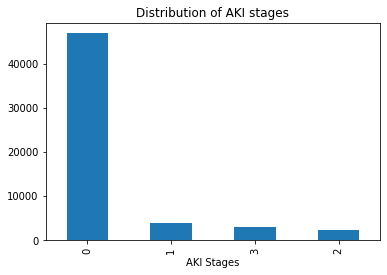

In [13]:
df["aki_stage"].value_counts().plot.bar()
plt.title("Distribution of AKI stages")
plt.xlabel("AKI Stages")
plt.show()

In [14]:
# We can observe that our dataset is extremly umbalanaced with too many class 0
# This may cause overfitting, so we want to some of class 0
df["aki_stage"].value_counts()

0    46867
1     3995
3     2951
2     2280
Name: aki_stage, dtype: int64

In [15]:
# Only keep 10 percent of the original class 0
df = df.drop(df[df['aki_stage'] == 0].sample(frac=.9).index)
print(df["aki_stage"].value_counts())

0    4687
1    3995
3    2951
2    2280
Name: aki_stage, dtype: int64


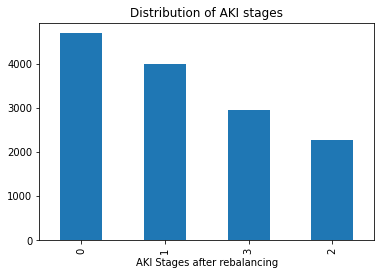

In [16]:
df["aki_stage"].value_counts().plot.bar()
plt.title("Distribution of AKI stages")
plt.xlabel("AKI Stages after rebalancing")
plt.show()
# We can see that the class distribution is much balance now

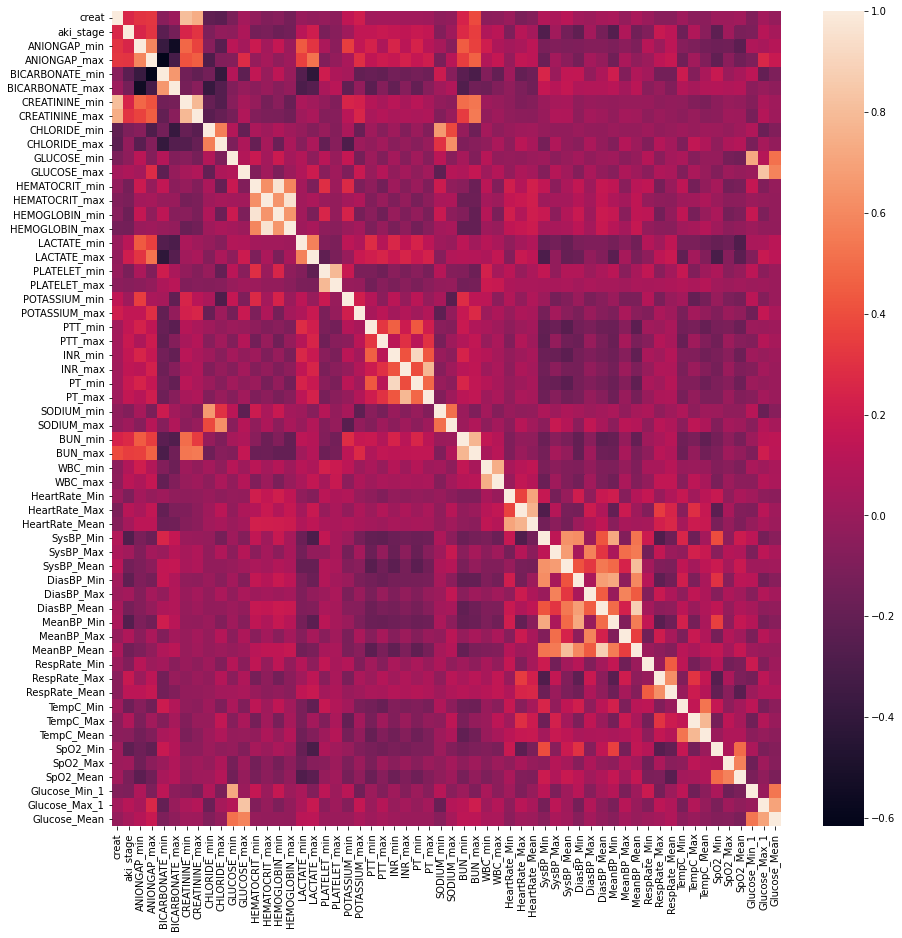

In [101]:
# Let's take a look at the correlation matrix
import seaborn as sns
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr())
plt.show()

### Train Test Split

For this part, we want to split our dataset into train and test dataset. The test dataset will be used for unsupervised clustering and evaluate our supervised learning's prediction performance on each of these clusters.

In [17]:
# First split into features and labels
df_y = df["aki_stage"]
df_X = df.drop(["aki_stage"], axis=1)
# Turn the dataframes into numpy arrays for further calulation
y = df_y.to_numpy()
X= df_X.to_numpy()

In [18]:
print(X.shape, "\n", y.shape)

(13913, 57) 
 (13913,)


In [58]:
# Train test split
# 30% would be a good percenatge for testing our model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=2021)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9739, 57) (4174, 57) (9739, 4) (4174, 4)


### Standarization

The range of different feature values varies a lot. We need to standardize them after the train test plit incase of leakage of information.

In [89]:
# Train Data Scaler
train_scaler = preprocessing.StandardScaler().fit(X_train)
# mean, scale
print("means:", "\n", train_scaler.mean_)
print("scales:", "\n", train_scaler.scale_)

means: 
 [  1.84649494  11.81288618  18.19630771  20.78824278  27.7537869
   1.43538202   2.49657434  99.19700979 108.35224064  91.0365113
 208.84532182  27.60300547  36.49143749   9.27758806  12.10635915
   1.6782798    3.4973214  173.08650166 276.75517883   3.53918604
   5.09336942  30.15187613  56.95724097   1.27854688   2.05623405
  14.18806456  19.64763718 134.53077617 142.03542091  22.66438553
  41.99778306   8.58391332  15.93617077  66.90684517 115.6465446
  87.92758742  82.51405219 159.36500186 118.82490303  37.50268744
  92.70578031  59.68939834  50.73606065 118.30359047  77.31576575
  10.63833471  31.19015359  19.43058949  35.72828278  37.75591201
  36.78968591  85.64249099  99.7227683   96.65832637  91.85319125
 214.67673268 138.18524456]
scales: 
 [  1.83904475   3.62353669   5.54317317   5.17519265   5.01089235
   1.45703769   2.87575176   6.12249937   6.33690324  31.16941089
 118.43045153   6.76346603   5.81654589   2.29133652   2.00762477
   1.28312882   3.05850793 103.3

In [90]:
# Fit
X_train = train_scaler.transform(X_train)

In [96]:
print(X_train.std(axis=0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [97]:
# Train Data Scaler
test_scaler = preprocessing.StandardScaler().fit(X_test)
# Fit
X_test = test_scaler.transform(X_test)

Now we are ready to train our models with our preprocessed dataset

## Unsupervised Clustering

Let's first try to visualize our high dimensional data, here I have tried two different method SVM and tSNE

In [106]:
time_start = time.time()

pca = PCA(n_components=4)
pca_result = pca.fit_transform(X_test)

print("PCA done! Time elapsed {} seconds".format(time.time() - time_start))

PCA done! Time elapsed 0.09531712532043457 seconds


In [107]:
# Check the PCA components
pca_df = pd.DataFrame(columns=["PCA1", "PCA2", "PCA3", "PCA4"])

for i in range(4):
  pca_df["PCA{}".format(i+1)] = pca_result[:, i]

print("Variance explained per principle component: {}".format(pca.explained_variance_ratio_))
print(pca_df)

Variance explained per principle component: [0.12352456 0.07631188 0.07476888 0.07274464]
          PCA1      PCA2      PCA3      PCA4
0     1.384440 -1.352151  1.849144 -3.616995
1    -2.253957  1.282445  3.381185  0.445850
2    -0.510759  4.445815 -4.955258  0.772046
3     1.403799 -1.960232  0.131302 -0.617454
4    -1.444025 -1.559995 -0.104730  2.206909
...        ...       ...       ...       ...
4169 -0.133238 -0.659124  1.065425 -3.319527
4170 -2.105308 -0.952170  1.075129 -1.287084
4171  3.282638  0.108808  2.013710  1.009496
4172 -0.726684 -0.940083 -0.288449 -1.282435
4173 -4.138474  0.555074  0.276406  0.572774

[4174 rows x 4 columns]


In [109]:
# Utility function to visualize the outputs of PCA and t-SNE

def grouping_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts 

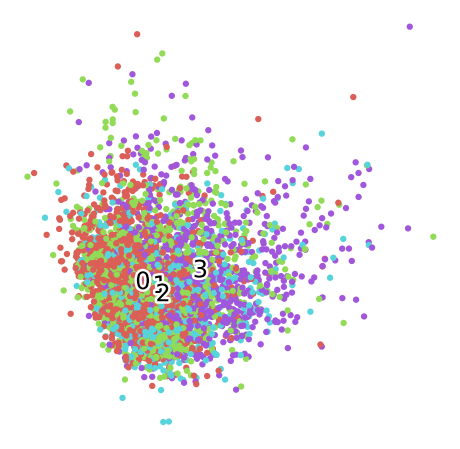

In [113]:
# Visualize the first two components
top_two_comp = pca_df[["PCA1", "PCA2"]]

grouping_scatter(top_two_comp.values, y_test)
plt.show()

We can see that the first two PCA components cannot explain the variance, and we cannot tell the difference of the groups. Let's try tSNE now.

In [51]:
# Before the tSNE first use the PCA
time_start = time.time()

pca_20 = PCA(n_components=20)
pca_result_20 = pca_20.fit_transform(X_test)

print("PCA with 20 components done! Time elapsed: {} seconds".format(time.time() - time_start))
print("cuculative variance exlained by 20 principle components: {}".format(np.sum(pca_20.explained_variance_ratio_)))

PCA with 20 components done! Time elapsed: 0.0627145767211914 seconds
cuculative variance exlained by 20 principle components: 0.839594108338668


In [134]:
time_start = time.time()

pca_20_tsne = TSNE(random_state=2021).fit_transform(pca_result_20)
print("t-SNE done! Time elapsed: {} seconds".format(time.time()-time_start))

t-SNE done! Time elapsed: 28.583620309829712 seconds


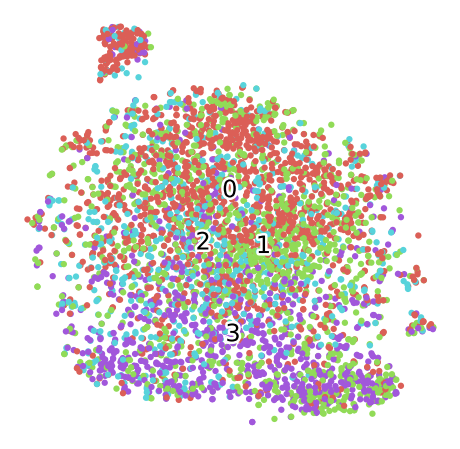

In [135]:
# Visualize the tSNE
grouping_scatter(pca_20_tsne, y_test)
plt.show()

From the tSNE we can see that the stage 0 and stage 3 are clearly seperated while stage 2 and stage 1 are mixed together.  
We can anticipate that our clustering results may not be good.

Now let's try to reduce the dimensionality of our data and use kmeans clustering to cluster it.

### KMeans

In [129]:
def kmeans_elbow_viz(data):
    sum_of_squared_distance = []
    n_cluster = range(1, 11)
    
    for k in n_cluster:
        kmean_model = KMeans(n_clusters=k)
        kmean_model.fit(data)
        sum_of_squared_distance.append(kmean_model.inertia_)
    
    plt.plot(n_cluster, sum_of_squared_distance, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow method for optimal K')
    plt.show();

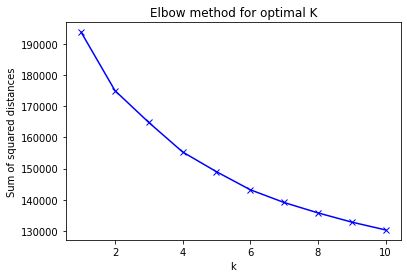

In [132]:
kmeans_elbow_viz(pca_result_20)

K = 4


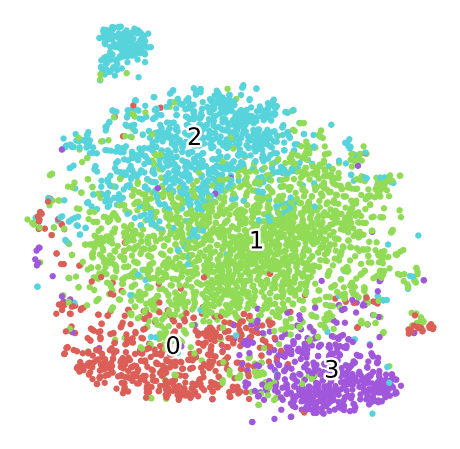

K = 5


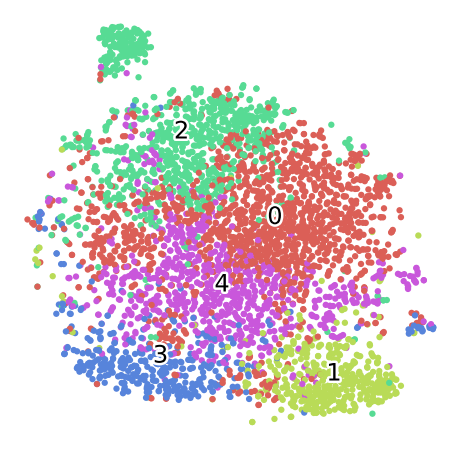

K = 6


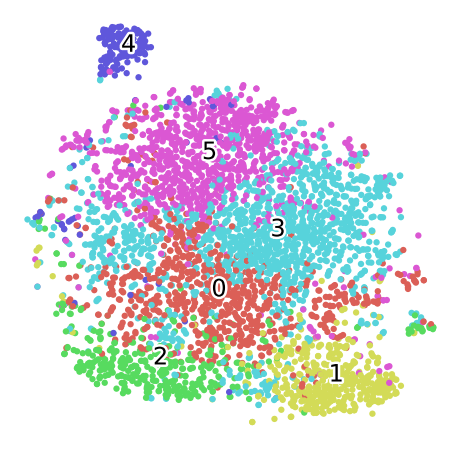

K = 7


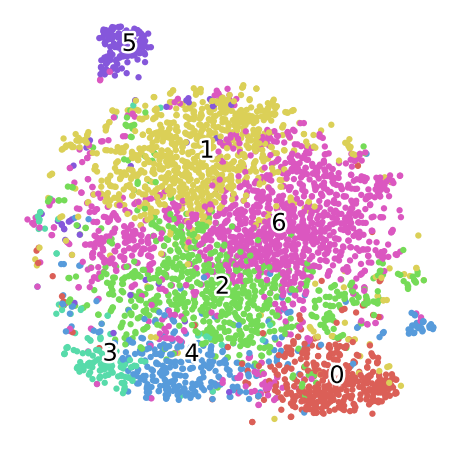

K = 8


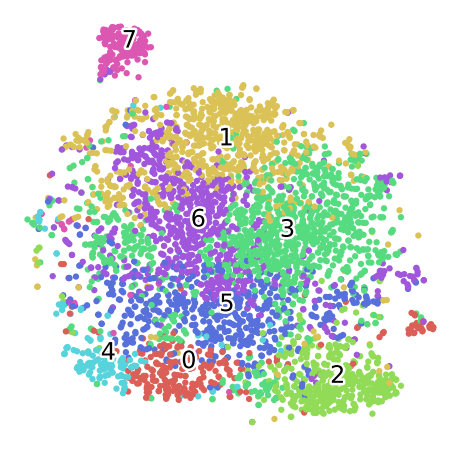

K = 9


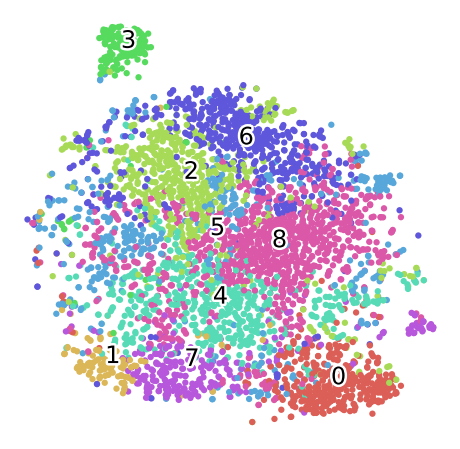

In [141]:
for num in range(4, 10):
  # Train the clustering method
  kmeans_model = KMeans(n_clusters=num)
  y_cluster = kmeans_model.fit_predict(pca_result_20)

  # Visualize the tSNE
  print("K = {}".format(num))
  grouping_scatter(pca_20_tsne, y_cluster)
  plt.show()

According to these plots, it seems that K=6 would be a good parameters for clustering our data.

In [143]:
def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

def get_class_rules(tree: DecisionTreeClassifier, feature_names: list):
  inner_tree: _tree.Tree = tree.tree_
  classes = tree.classes_
  class_rules_dict = dict()

  def tree_dfs(node_id=0, current_rule=[]):
    # feature[i] holds the feature to split on, for the internal node i.
    split_feature = inner_tree.feature[node_id]
    if split_feature != _tree.TREE_UNDEFINED: # internal node
      name = feature_names[split_feature]
      threshold = inner_tree.threshold[node_id]
      # left child
      left_rule = current_rule + ["({} <= {})".format(name, threshold)]
      tree_dfs(inner_tree.children_left[node_id], left_rule)
      # right child
      right_rule = current_rule + ["({} > {})".format(name, threshold)]
      tree_dfs(inner_tree.children_right[node_id], right_rule)
    else: # leaf
      dist = inner_tree.value[node_id][0]
      dist = dist/dist.sum()
      max_idx = dist.argmax()
      if len(current_rule) == 0:
        rule_string = "ALL"
      else:
        rule_string = " and ".join(current_rule)
      # register new rule to dictionary
      selected_class = classes[max_idx]
      class_probability = dist[max_idx]
      class_rules = class_rules_dict.get(selected_class, [])
      class_rules.append((rule_string, class_probability))
      class_rules_dict[selected_class] = class_rules
    
  tree_dfs() # start from root, node_id = 0
  return class_rules_dict

def cluster_report(data: pd.DataFrame, clusters, min_samples_leaf=50, pruning_level=0.01):
    # Create Model
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, ccp_alpha=pruning_level)
    tree.fit(data, clusters)
    
    # Generate Report
    feature_names = data.columns
    class_rule_dict = get_class_rules(tree, feature_names)

    report_class_list = []
    for class_name in class_rule_dict.keys():
        rule_list = class_rule_dict[class_name]
        combined_string = ""
        for rule in rule_list:
            combined_string += "[{}] {}\n\n".format(rule[1], rule[0])
        report_class_list.append((class_name, combined_string))
        
    cluster_instance_df = pd.Series(clusters).value_counts().reset_index()
    cluster_instance_df.columns = ['class_name', 'instance_count']
    report_df = pd.DataFrame(report_class_list, columns=['class_name', 'rule_list'])
    report_df = pd.merge(cluster_instance_df, report_df, on='class_name', how='left')
    pretty_print(report_df.sort_values(by='class_name')[['class_name', 'instance_count', 'rule_list']])

In [154]:
# To analyze the classification result, we have to regenerate a pandas dataframe.
X_test_df = pd.DataFrame(X_test, columns=list(df_X.columns))

In [156]:
kmeans_model = KMeans(n_clusters=6)
y_cluster = kmeans_model.fit_predict(pca_result_20)
cluster_report(X_test_df, y_cluster)

,class_name,instance_count,rule_list
2,0,778,[0.4878048780487805] (MeanBP_Mean <= 0.1133725605905056) and (ANIONGAP_max <= 0.0680175730958581) and (SysBP_Max > 0.3977928161621094)[0.43577981651376146] (MeanBP_Mean <= 0.1133725605905056) and (ANIONGAP_max > 0.0680175730958581) and (INR_min <= 0.5028626918792725) and (creat <= 0.6550358235836029)[0.4632352941176471] (MeanBP_Mean > 0.1133725605905056) and (creat <= 0.9133410751819611) and (SysBP_Min <= 0.23088382184505463) and (HeartRate_Mean <= 1.915018081665039)
1,1,1008,[0.7959413754227734] (MeanBP_Mean > 0.1133725605905056) and (creat <= 0.9133410751819611) and (SysBP_Min > 0.23088382184505463)
4,2,376,[0.740484429065744] (MeanBP_Mean <= 0.1133725605905056) and (ANIONGAP_max > 0.0680175730958581) and (INR_min > 0.5028626918792725)
0,3,1380,[0.7766749379652605] (MeanBP_Mean <= 0.1133725605905056) and (ANIONGAP_max <= 0.0680175730958581) and (SysBP_Max <= 0.3977928161621094)
5,4,206,[0.9349112426035503] (MeanBP_Mean > 0.1133725605905056) and (creat <= 0.9133410751819611) and (SysBP_Min <= 0.23088382184505463) and (HeartRate_Mean > 1.915018081665039)
3,5,426,[0.75] (MeanBP_Mean <= 0.1133725605905056) and (ANIONGAP_max > 0.0680175730958581) and (INR_min <= 0.5028626918792725) and (creat > 0.6550358235836029)[0.908256880733945] (MeanBP_Mean > 0.1133725605905056) and (creat > 0.9133410751819611)


In [159]:
occurance_df = pd.DataFrame({
    "Group Number": list(y_cluster),
    "KDIGO Stage": list(y_test)
})

In [169]:
occurance_df.groupby(["Group Number", "KDIGO Stage"])["Group Number"].count()

Group Number  KDIGO Stage
0             0              177
              1              172
              2              200
              3              229
1             0              526
              1              278
              2              150
              3               54
2             0               32
              1               76
              2               73
              3              195
3             0              546
              1              480
              2              215
              3              139
4             0              138
              1               12
              2               25
              3               31
5             0               37
              1              167
              2                9
              3              213
Name: Group Number, dtype: int64

The different occurance frequency of different KDIGO Stages in different clustering group number may provide us some very useful prediction information.  
For example in clustering group 2, we have far more patients result in stage3 than any other stages. By looking up the clustering rule table, we could use the rules as early warning(prediction) for the AKI that may happen later.

In [173]:
# Save both the SVM and k-means model
pickle.dump(pca_20, open("/content/saved_model/PCA20.sav", "wb"))
pickle.dump(kmeans_model, open("/content/saved_model/KMeans6.sav", "wb"))

## Supervised classification

### General Models Performance

To evaluate the performance of our supervised learning model more impartially, here I used the nested cross-validation method to tune the hyperparameters and assess the classification performance. The nested cross-validation process is shown as below.

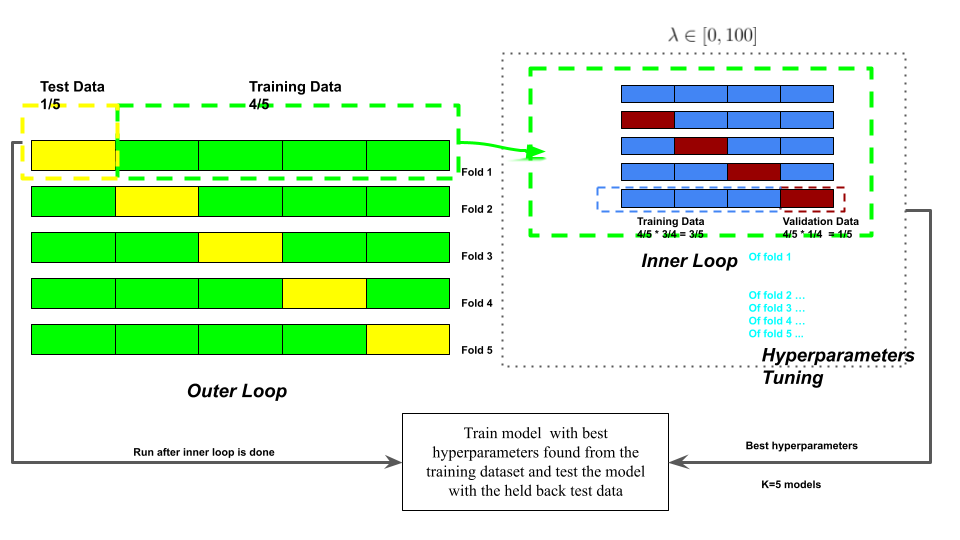

In [174]:
# Visualize the cross-validation process
def visualize():
  sns.set_theme()
  plt.figure(figsize=(15, 7))
  # Error bar
  plt.errorbar(lambdas, 1-means, stds, color="black", ecolor="red",  capsize=4, label="\u00B5E(\u03BB) \u00B1 \u03C3E(\u03BB)")
  # Minimum Error
  plt.plot(lambdas[min_index], 1-means[min_index], "bo", label="\u00B5E(\u03BBmin)")
  plt.axvline(x=lambdas[min_index], color="blue", linestyle="--")
  # Error of lambda star
  plt.plot(lambda_star, 1-means[star_index], "go", label="\u00B5E(\u03BB*)")
  plt.axvline(x=lambda_star, color="green", linestyle="--")

  plt.title("Cross-Validated Classification Error Rate of\nLogistic Regression with Elasticnet Regularization\nAlpha=0.95")
  plt.xscale("log")
  plt.xlabel("Lambdas (log scale)")
  plt.ylabel("Classification Error")
  plt.legend()
  plt.show()

  return

In [64]:

# importing necessary libraries
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
 
 
# training a DescisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
dtree_model = DecisionTreeClassifier(max_depth = 3).fit(X_train, y_train)
train_predict = dtree_model.predict(X_train)
test_predictions = dtree_model.predict(X_test)
 
print(classification_report(y_test, test_predictions, labels=[0, 1, 2, 3]))
print(classification_report(y_train, train_predict, labels=[0, 1, 2, 3]))

              precision    recall  f1-score   support

           0       0.80      0.24      0.37      1445
           1       0.57      0.31      0.40      1175
           2       0.00      0.00      0.00       703
           3       0.60      0.62      0.61       851

   micro avg       0.63      0.30      0.40      4174
   macro avg       0.49      0.29      0.34      4174
weighted avg       0.56      0.30      0.36      4174
 samples avg       0.30      0.30      0.30      4174

              precision    recall  f1-score   support

           0       0.82      0.25      0.38      3242
           1       0.58      0.32      0.42      2820
           2       0.00      0.00      0.00      1577
           3       0.64      0.63      0.63      2100

   micro avg       0.66      0.31      0.42      9739
   macro avg       0.51      0.30      0.36      9739
weighted avg       0.58      0.31      0.38      9739
 samples avg       0.31      0.31      0.31      9739



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score

y = pd.get_dummies(df["aki_stage"]).to_numpy()

# get the model
def get_model(n_inputs, n_outputs):
	model = Sequential()
	model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
	model.add(Dense(n_outputs, activation='sigmoid'))
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
	return model

# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
	results = list()
	n_inputs, n_outputs = X.shape[1], y.shape[1]
	# define evaluation procedure
	cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
	# enumerate folds
	for train_ix, test_ix in cv.split(X):
		# prepare data
		X_train, X_test = X[train_ix], X[test_ix]
		y_train, y_test = y[train_ix], y[test_ix]
		# define model
		model = get_model(n_inputs, n_outputs)
		# fit model
		model.fit(X_train, y_train, verbose=1, epochs=150)
		# make a prediction on the test set
		yhat = model.predict(X_test)
		# round probabilities to class labels
		yhat = yhat.round()
		# calculate accuracy
		acc = accuracy_score(y_test, yhat)
		# store result
		print('>%.3f' % acc)
		results.append(acc)
	return results

# evaluate model
results = evaluate_model(X, y)
# summarize performance
print('Accuracy: %.3f (%.3f)' % (mean(results), std(results)))

Epoch 1/150
348/348 [==============================] - 1s 2ms/step - loss: 6.1429 - accuracy: 0.3012
Epoch 2/150
348/348 [==============================] - 1s 2ms/step - loss: 1.3567 - accuracy: 0.3182
Epoch 3/150
348/348 [==============================] - 1s 2ms/step - loss: 0.9049 - accuracy: 0.3470
Epoch 4/150
348/348 [==============================] - 1s 2ms/step - loss: 0.7130 - accuracy: 0.3711
Epoch 5/150
348/348 [==============================] - 1s 2ms/step - loss: 0.6213 - accuracy: 0.3699
Epoch 6/150
348/348 [==============================] - 1s 2ms/step - loss: 0.5841 - accuracy: 0.3644
Epoch 7/150
348/348 [==============================] - 1s 2ms/step - loss: 0.5701 - accuracy: 0.3606
Epoch 8/150
348/348 [==============================] - 1s 2ms/step - loss: 0.5633 - accuracy: 0.3580
Epoch 9/150
348/348 [==============================] - 1s 2ms/step - loss: 0.5584 - accuracy: 0.3603
Epoch 10/150
348/348 [==============================] - 1s 2ms/step - loss: 0.5579 - accura